In [4]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [5]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x,d):
    cur_prod = 1.0
    for i in range(d):
        cur_prod = cur_prod*H(k[i],x[:,i])
    return cur_prod

In [6]:
def generate_lexicographical_2nd_order(d):
    """
    function to generate lexigoraphical polynomials of 1st and 2nd order
    """
    cur_list = []
    for i in range(d):
        cur_permute = np.zeros(d,dtype = int)
        cur_permute[i] = 1
        cur_list.append(np.copy(cur_permute))
        cur_permute[i] = 0
    for i in range(d):
        cur_permute = np.zeros(d,dtype = int)
        cur_permute[i] = 2
        cur_list.append(np.copy(cur_permute))
        cur_permute[i] = 1
        for j in range(i+1,d):
            cur_permute[j] = 1
            cur_list.append(np.copy(cur_permute))
            cur_permute[j] = 0
    return cur_list

a = generate_lexicographical_2nd_order(3)
print(a)

[array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([2, 0, 0]), array([1, 1, 0]), array([1, 0, 1]), array([0, 2, 0]), array([0, 1, 1]), array([0, 0, 2])]


In [7]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = generate_lexicographical_2nd_order(d)
    poly_deg = 2
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((poly_deg,N_test), dtype = float)
    #for k in range(len(basis_funcs)):
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k+1,Noise[:,0])
    #initialize function
    #f_vals_vanilla = np.copy(X_test[:,0])
    f_vals_vanilla = np.sum(X_test,axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1st_order = np.zeros((lag,N_test),dtype=float)
    bar_a_2nd_order = np.zeros((lag,N_test),dtype=float)
    #preprocessing 
    X_test = np.concatenate((x0.reshape(1,d),X_test),axis=0)
    coefs_poly_1st_order = np.zeros((lag,d),dtype=float)
    coefs_poly_1st_order = coefs_poly_regr[:,1:d+1]
    coefs_poly_2nd_order = np.zeros((lag,d,d),dtype=float)
    counter = 0
    for i in range(d):
        for j in range(i,d):
            coefs_poly_2nd_order[:,i,j] = coefs_poly_regr[:,d+1+counter]
            counter += 1
    for i in range(lag):
        #first-order coefficients
        for j in range(d):
            bar_a_1st_order[i,:] += coefs_poly_1st_order[i,j]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]
            #sum more coefficients
            for k in range(j):
                bar_a_1st_order[i,:] += coefs_poly_2nd_order[i,k,j]*np.sqrt(gamma)*((sigma(X_test[:-1])[:,j]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,k])+\
                                      sigma(X_test[:-1])[:,k]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,j])
                                        
            #diagonal part
            bar_a_1st_order[i,:] += 2*coefs_poly_2nd_order[i,j,j]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]*((X_test[:-1]+gamma*b(X_test[:-1]))[:,j])
            #sum more coefficients
            for k in range(j+1,d):
                bar_a_1st_order[i,:] += coefs_poly_2nd_order[i,j,k]*np.sqrt(gamma)*(sigma(X_test[:-1])[:,j]*((X_test[:-1]+gamma*b(X_test[:-1]))[:,k])+\
                                    sigma(X_test[:-1])[:,k]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,j])
            #second-order coefficients, to be filled
            bar_a_2nd_order[i,:] += coefs_poly_2nd_order[i,j,j]*np.sqrt(2)*gamma*(sigma(X_test[:-1])[:,j])**2
            for k in range(j+1,d):
                bar_a_2nd_order[i,:] += np.sqrt(2)*coefs_poly_2nd_order[i,j,k]*gamma*sigma(X_test[:-1])[:,j]*sigma(X_test[:-1])[:,k]
    bar_a_1st_order = poly_vals[0,:]*bar_a_1st_order 
    bar_a_2nd_order = poly_vals[1,:]*bar_a_2nd_order
    #compute martingale sums
    M_n_1st = 0.0
    M_n_2nd = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1st += bar_a_1st_order[r,l]
            M_n_2nd += bar_a_2nd_order[r,l]
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla) - M_n_1st/N_test, np.mean(f_vals_vanilla) - M_n_2nd/N_test
#
#
#

In [8]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [9]:
sig = 0.05
r_vect = np.array([4.0,3.0,1.0,0.5],dtype=float)
rate_matr = np.array([[0.2,0.1,0.3,0.2],[0.1,0.2,0.1,0.3],[-0.2,-0.1,0.4,0.0],[-0.1,-0.3,0.0,0.4]],dtype=float)

#sig_matr = np.array([[0.1,0.0,0.0,0.0],[0.0,0.05,0.0,0.0],[0.0,0.0,0.05,0.0],[0.0,0.0,0.0,0.05]],dtype=float)
sig_matr = sig*np.eye(4)

def b(X_t):
    """
    b function in the diffusion
    """
    #return a*(c-X_t)
    if len(X_t.shape) == 1:
        dyn_part = r_vect - rate_matr @ X_t
        return X_t*dyn_part
    else:
        const_part = r_vect.reshape((1,4))
        dyn_part = const_part - X_t @ rate_matr.T
        return X_t*dyn_part

def sigma(X_t):
    """
    b function in the diffusion
    """
    if len(X_t.shape) == 1:
        return (sig_matr @ np.copy(X_t))*np.copy(X_t)
    else:
        return (np.copy(X_t) @ sig_matr)*np.copy(X_t)

def sample_discretized_diffusion(X_t,gamma_t,d):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn()*np.ones(d)
    #xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(gamma_t)*sigma(X_t)*xi,xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [10]:
n = 1*10**5 #sample size
gamma = 5e-2 # Step size
n_traj = 10
d = 4
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "quadratic"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 100 #maximal lag order
N_test = 2*10**3

Sample discretized diffusion

In [11]:
def generate_observations(x0,n,gamma,r_seed,d,n_traj):
    X_train_all = np.zeros((n_traj,n,d),dtype=float)
    Noise_train_all = np.zeros_like(X_train_all)
    Y_train_all = np.zeros((n_traj,n,1),dtype=float)
    nbcores = multiprocessing.cpu_count()
    trav = Pool(nbcores)
    train_traj = trav.starmap(generate_traj, [(x0,n,gamma,r_seed+i,d) for i in range (n_traj)])
    #res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
    trav.close()
    train_traj = np.asarray(train_traj)
    #print(train_traj.shape)
    X_train_all = train_traj[:,0,:,:]
    Noise_train_all = train_traj[:,1,:,:]
    #Y_train_all[:,:,0] = np.copy(X_train_all[:,:,0])
    Y_train_all[:,:,0] = np.sum(X_train_all,axis=2)
    #X_train, noise_train = generate_traj(x0,n,gamma,r_seed,d)
    #set target function
    #Y_train = np.sum(X_train,axis=1)
    #X_train = X_train.reshape((1,-1,d))
    #Y_train = Y_train.reshape((1,-1,1))
    return X_train_all, Noise_train_all, Y_train_all

In [12]:
x0 = np.array([7.0,6.0,5.0,5.0])
r_seed = 1812
X_train, noise_train, Y_train = generate_observations(x0,n,gamma,r_seed,d,n_traj)

In [13]:
print(Y_train.shape)
print(X_train.shape)

(10, 100000, 1)
(10, 100000, 4)


In [14]:
print(X_train[0,5000:5100,:])

[[ 4.78437473  2.46519694  5.54238248  4.46970376]
 [ 4.81760284  2.47521897  5.5061866   4.43298822]
 [ 4.96639127  2.51622522  5.62408292  4.49704473]
 [ 5.16589292  2.56784402  5.8249452   4.61568249]
 [ 5.25301927  2.58719531  5.9111214   4.66341739]
 [ 5.20374733  2.57196774  5.83754081  4.61286028]
 [ 5.15650283  2.55832681  5.75802743  4.55770093]
 [ 5.74184815  2.70150163  6.45951093  4.99100391]
 [ 5.50703217  2.63724177  6.23777751  4.86260683]
 [ 5.91282714  2.72230858  6.7916996   5.19876919]
 [ 5.28722202  2.57205808  6.0848988   4.79215463]
 [ 5.41830344  2.59776354  6.25672392  4.89332063]
 [ 5.36395314  2.57753081  6.20636244  4.8596735 ]
 [ 5.22359604  2.538491    6.03031233  4.74804276]
 [ 5.552495    2.61239891  6.45433978  5.00476561]
 [ 5.72109071  2.63937262  6.7302946   5.170661  ]
 [ 5.22090591  2.51821962  6.12516985  4.81706771]
 [ 5.82238295  2.65354234  6.94069968  5.3146908 ]
 [ 5.821112    2.63478606  7.05652709  5.38731135]
 [ 6.29867475  2.7129523   7.88

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [15]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
#print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
poly = PolynomialFeatures(S_max)
features = poly.fit_transform(X_train[0])
#features = np.zeros((X_train.shape[1],6),dtype=float)
#features[:,0] = 1.0
#features[:,1:3] = X_train[0,:,:]
#features[:,3] = X_train[0,:,0]**2 
#features[:,4] = X_train[0,:,0]*X_train[0,:,1]
#features[:,5] = X_train[0,:,1]**2
for i in range(len(regr_vals)):
    regr_vals[i,:] = np.sum(coefs_poly[i,:]*features,axis=1)

[[-9.58866862e-14  1.00000000e+00  1.00000000e+00 ... -1.55218257e-15
   4.07590935e-15 -4.93483569e-15]
 [-1.59249495e-01  1.35459097e+00  9.80943568e-01 ... -1.54378844e-02
  -8.70514184e-03 -1.33663706e-02]
 [-1.22495762e-01  1.79688335e+00  8.26653192e-01 ... -2.12250231e-02
   3.56141800e-02 -8.48551141e-02]
 ...
 [ 1.94033004e+01 -5.91923720e-01  1.07525038e-01 ... -1.24580616e-01
   4.97959645e-01 -4.60658921e-01]
 [ 1.91822123e+01 -5.32524193e-01  4.37207636e-02 ... -3.52373590e-01
   1.08298181e+00 -8.41460952e-01]
 [ 1.90036408e+01 -5.27948644e-01  9.26910054e-02 ... -5.14435391e-01
   1.48928823e+00 -1.09954432e+00]]


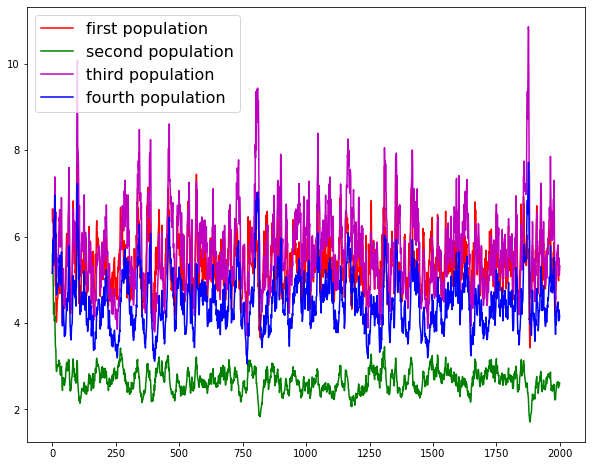

In [16]:
plt.figure(figsize=(10, 8))
#plt.title("Testing regression model",fontsize=20)
plt.plot(X_train[0,:2000,0],color='r',label='first population')
plt.plot(X_train[0,:2000,1],color='g',label='second population')
plt.plot(X_train[0,:2000,2],color='m',label='third population')
plt.plot(X_train[0,:2000,3],color='b',label='fourth population')
plt.legend(loc = 'upper left',fontsize = 16)
plt.savefig('./4d_lotka_volterra_coupled_dyn_02_12.pdf')
#plt.show()

Test our regressors

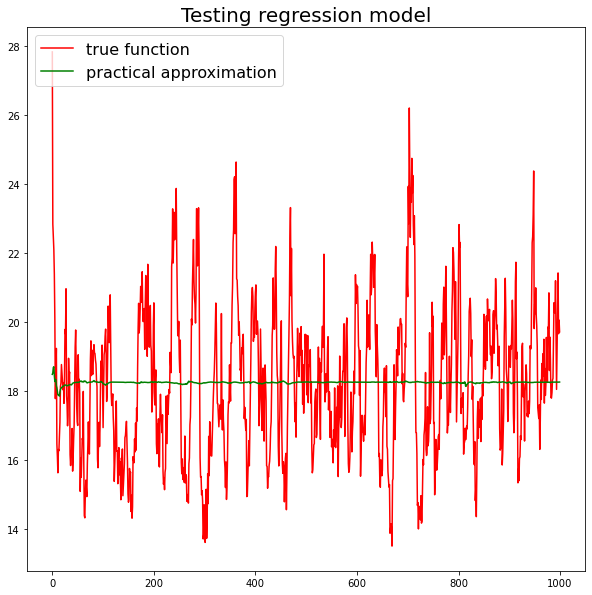

In [17]:
cur_lag = 99
N_pts = 1000
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [18]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,d,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res = np.asarray(res)
print(res.shape)

(100, 3)


### Comparison plots

In [19]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MAD-CV-1','Euler scheme \nwith MAD-CV-2']

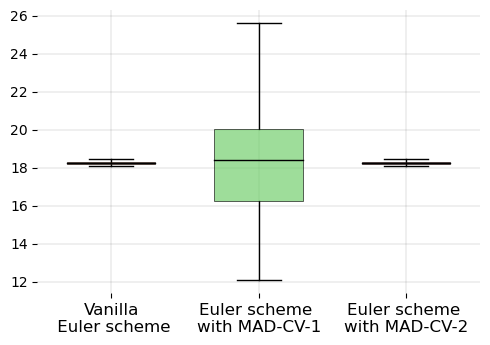

In [20]:
data = [res[:,0], res[:,1], res[:,2]] 
boxplot_ind(data, title, labels,path="./multidim_lotka_vorterra_4_d_02_12_gamma_2e-2_coupled_dyn.pdf")

In [ ]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [ ]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['Vanilla \n Euler scheme','MDCV-2, \n $N = 10^3$', 'MDCV-2, \n $N = 2 \\times 10^3$',\
          'MDCV-2, \n $N = 5 \\times 10^3$', 'MDCV-2, \n $N = 10^4$', 'MDCV-2, \n $N = 5 \\times 10^4$']
#labels = ['lag \n = 10','lag \n = 20', 'lag \n = 30', 'lag \n = 40', 'lag \n = 50', 'lag \n = 60']
#labels = ['lag = 30', 'lag = 40', 'lag = 50', 'lag = 60']

In [ ]:
data = [res_new_0[:,0],res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_quadratic_regression_comparison.pdf")

In [ ]:
data = [res_new_0[:,0],res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_lags_comparison.pdf")